In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import EarthLocation,SkyCoord
from astroplan import Observer, FixedTarget
from astroplan.plots import plot_sky
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz
from ipywidgets import interact

In [2]:
import seaborn as sns
sns.set(font="times",font_scale=1.5,style="ticks")
%config InlineBackend.figure_formats = {'png', 'retina'}

### 観測サイトの指定(@SALT)

In [3]:
salt = Observer.at_site("SALT")
observing_location = EarthLocation(lat=-32.3763*u.deg, lon=20.8107*u.deg, height=1798*u.m)

### 観測時刻の指定(UTC)

In [4]:
# UTを入れる
Year='2023'
Month='9'
Day='16'
Hour='00'

### ターゲットリストの読み込み

In [5]:
target_list = "./2mass_catalog/table_irsa_catalog_search_results_tmp.csv"

### 高度リミットの指定

In [6]:
low = 35     ## [°]
upper =  83  ## [°]

### function

In [7]:
tt = pd.read_csv(target_list, delimiter=",")
targets = [FixedTarget(coord=SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))) for ra, dec in zip(tt.ra, tt.dec)]
def func(year, month, day, hour, save_csv=False):
    time = Time(f"{year}-{month}-{day} {hour}:00")
    fig = plt.figure(figsize=(6, 6))
    plot_sky(targets, salt, time, style_kwargs={'marker': '.', 'alpha': 0.3, 'color': 'gray'}) # all stars
    
    ##### alt limit #####
    theta = np.arange(0, 360)
    low_limit = [90-low] * len(theta)
    upper_limit = [90-upper] * len(theta)
    plt.plot(theta, low_limit, '.', color='C1', markersize=4, label=f'limit : {low}°, {upper}°')
    plt.plot(theta, upper_limit, '.', color='C1', markersize=2)
    #################
    
    ##### observable stars #####
    altitude = (91 * u.deg - salt.altaz(time, targets).alt) * (1/u.deg)
    index = np.where((altitude <= 90-low) & (altitude >= 90-upper))
    observable = [tt.loc[idx, ["ra", "dec", "h_m"]] for idx in index[0]]
    ############################
    
    ##### make DataFrame #####
    observable_df = pd.DataFrame(observable, columns=["ra", "dec", "h_m"])
    targets_radec = [SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg)) for ra, dec in zip(observable_df.ra, observable_df.dec)]
    altaz_frame = AltAz(obstime=time, location=observing_location)
    sorted_targets_radec = sorted(targets_radec, key=lambda target: target.transform_to(altaz_frame).az) # sort by azimuth
    sorted_targets = [FixedTarget(coord=target) for target in sorted_targets_radec]

    azimuths = [coord.transform_to(altaz_frame).az.degree \
            for coord in SkyCoord(ra=observable_df["ra"], dec=observable_df["dec"], unit=(u.deg, u.deg))]
    observable_df["azimuth"] = azimuths
    observable_df_azi = observable_df.sort_values(by="azimuth")
    observable_script_azi = observable_df_azi.drop(["h_m", "azimuth"], axis=1)
    ##########################

    plot_sky(sorted_targets, salt, time, style_kwargs={'marker': '.', 'color': 'C0'}) # observable stars
    plt.title(f"UTC, {year}-{month}-{day} {hour}:00", fontsize=18)
    plt.legend(bbox_to_anchor=(1.2, 1.1), shadow=True, fontsize=18)
    if save_csv:
        observable_script_azi.to_csv(f"./output/tpointscript_{year}{month}{day}T{hour}00.txt", index=True, header=False, index_label='id')
        observable_df_azi.to_csv(f"./output/tpoint_{year}{month}{day}T{hour}00.txt", index=True, index_label='id')
    print(observable_df_azi)

### "ipywidgets" を使う場合

In [8]:
# Use interact for widget-based interaction
interact(func, year=Year, month=Month, day=Day, hour=Hour, save_csv=False);

interactive(children=(Text(value='2023', description='year'), Text(value='9', description='month'), Text(value…

### "ipywidgets" を使わない場合

             ra        dec    h_m     azimuth
638  358.993272  21.165968  6.002    4.058670
778    2.710978   5.088806  6.003   11.691882
779    4.260281   2.371436  6.003   15.092635
780    6.726173   8.562753  6.002   16.601216
749   15.389841  11.942099  6.007   26.474485
..          ...        ...    ...         ...
772  334.827781  12.254126  6.004  332.790428
362  343.910972  -2.842278  6.001  337.523194
639  344.828595   4.358540  6.007  342.673799
191  353.030872  20.523722  6.004  357.127991
637  354.768105   0.123617  6.001  358.683336

[75 rows x 4 columns]


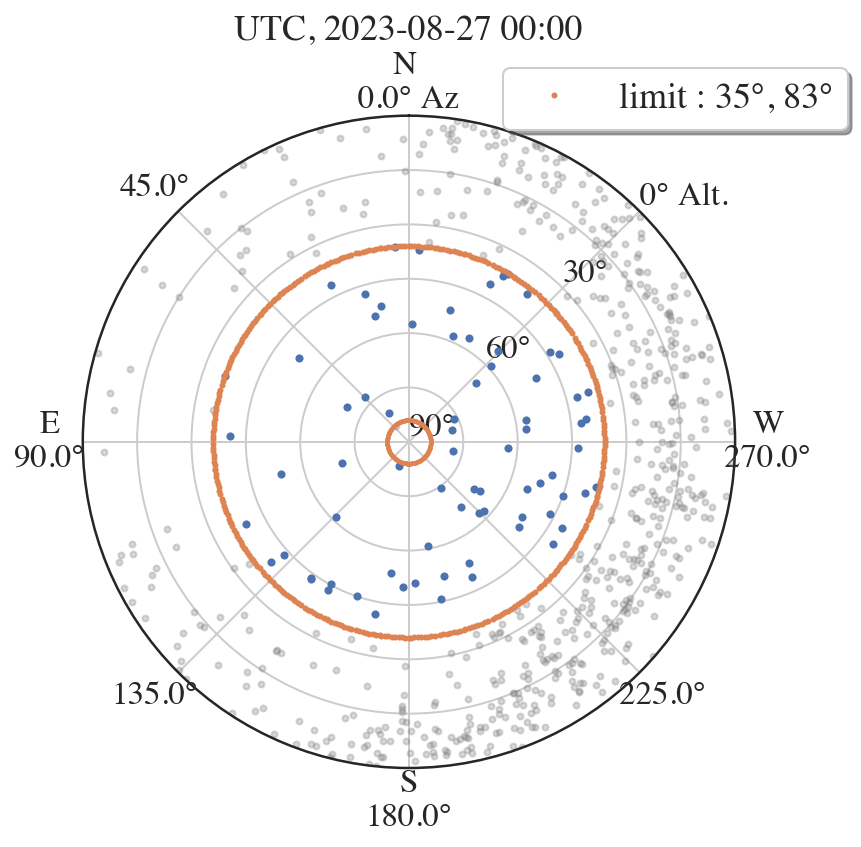

In [8]:
func(year=Year, month=Month, day=Day, hour=Hour, save_csv=False);